In [1]:
# LOAD DATA

%matplotlib inline 

import os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('WARN')

# Read in data. We need to read in the first row of the CSV 
# to get the headers so we can dynamically create the schema.
DATA_DIR = 'project_data/peaks_v2'
file_name = 'peak_1s.csv'

pd_df = pd.read_csv(os.path.join(DATA_DIR, file_name))
df = spark.createDataFrame(pd_df)

# confirm the labels are right
labels = df.select(df['label']).collect()
falls = [l for l in labels if l[0] == 1]
non_falls = [l for l in labels if l[0] == 0]
print("Falls: {}, Non-falls: {}".format(len(falls), len(non_falls)))

# Get all columns except trial_id and label as features
features = [col for col in df.columns if col not in ['trial', 'label', 'filename']]
train, validation = df.randomSplit([0.75, 0.25])

Falls: 3990, Non-falls: 60615


Weighted Precision: 0.9949818244564118
Weighted Recall: 0.9949966026314164
f1: 0.9949884363234217
Accuracy: 0.9949966026314164
Confusion matrix, without normalization
Normalized confusion matrix


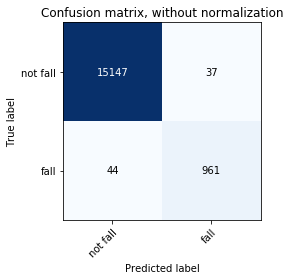

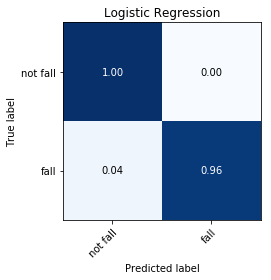

In [2]:
## LOGISTIC REGRESSION

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

# Set params to test
numFolds = 5
epochs = 100

# Assemble Pipeline
assembler = VectorAssembler(
    inputCols=features,
    outputCol='features')
classifier = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[assembler, classifier])

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [300]) \
    .addGrid(classifier.regParam, [0]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                          numFolds=numFolds)  
model = cv.fit(train)

predictions = model.transform(validation)
evaluator = BinaryClassificationEvaluator()
evaluator = MulticlassClassificationEvaluator()

print("Weighted Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
print("Weighted Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))


# CONFUSION MATRIX FOR LOGISTIC REGRESSION
class_names = [0, 1]
y_pred = predictions.select(predictions['prediction']).toPandas().to_numpy().astype(np.int8)
y_test = predictions.select(predictions['label']).toPandas().to_numpy().astype(np.int8)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['not fall','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Logistic Regression')

# plt.savefig('ConfusionMatrix_LR.png')
plt.show()

Precision: 0.50920245398773
Recall: 0.9360902255639098
F1: 0.6596026490066226
Accuracy: 0.940329695843975
Confusion matrix, without normalization
[[11403   720]
 [   51   747]]
Normalized confusion matrix
[[0.94 0.06]
 [0.06 0.94]]


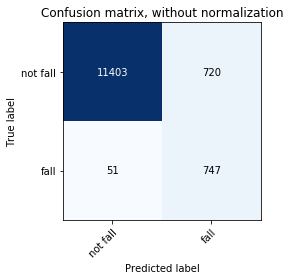

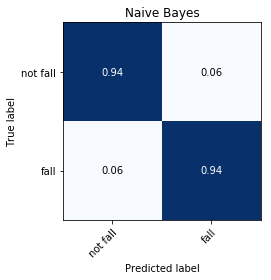

In [3]:
# NAIVE BAYES

import numpy as np 
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

cols = [col for col in df.columns]
df_nb = df.select(cols)

df_positive = df_nb.where(df_nb.label == 1).toPandas()
df_negative = df_nb.where(df_nb.label == 0).toPandas()

pos_rows = len(df_positive)
i_pos = int(0.8 * pos_rows)

neg_rows = len(df_negative)
i_neg = int(0.8 * neg_rows)

train_X_pos = df_positive[:i_pos].to_numpy()[:, 3:].astype(np.float32)
test_X_pos = df_positive[i_pos:].to_numpy()[:, 3:].astype(np.float32)
train_y_pos = df_positive['label'][:i_pos].to_numpy().astype(np.float32)
test_y_pos = df_positive['label'][i_pos:].to_numpy().astype(np.float32)

train_X_neg = df_negative[:i_neg].to_numpy()[:, 3:].astype(np.float32)
test_X_neg = df_negative[i_neg:].to_numpy()[:, 3:].astype(np.float32)
train_y_neg = df_negative['label'][:i_neg].to_numpy().astype(np.float32)
test_y_neg = df_negative['label'][i_neg:].to_numpy().astype(np.float32)

train_X = np.concatenate((train_X_pos, train_X_neg))
test_X = np.concatenate((test_X_pos, test_X_neg))
train_y = np.concatenate((train_y_pos, train_y_neg))
test_y = np.concatenate((test_y_pos, test_y_neg))

gnb = GaussianNB()
model = gnb.fit(train_X, train_y)
y_pred = model.predict(train_X)

def calculateAccuracy(actual, prediction):
    errors = np.sum((prediction-actual)**2)
    total = len(labels)
    percentCorrect = 1-errors/total
    return percentCorrect

test_pred = model.predict(test_X)
test_actual = test_y

d = {'prediction': test_pred, 'actual': test_actual}
results = pd.DataFrame(data=d)

true_positive = results.loc[results['prediction'] == 1].loc[results['actual'] == 1].count().to_numpy()[0]
false_positive = results.loc[results['prediction'] == 1].loc[results['actual'] == 0].count().to_numpy()[0]
true_negative = results.loc[results['prediction'] == 0].loc[results['actual'] == 0].count().to_numpy()[0]
false_negative = results.loc[results['prediction'] == 0].loc[results['actual'] == 1].count().to_numpy()[0]

true_positive_rate = true_positive/(true_positive + false_positive)
false_positive_rate = false_positive/(true_positive + false_positive)
true_negative_rate = true_negative/(true_negative + false_negative)
false_negative_rate = false_negative/(true_negative + false_negative)
accuracy = (true_positive + true_negative)/(true_positive + false_positive + true_negative + false_negative)
recall = true_positive/(true_positive + false_negative)
precision = true_positive/(true_positive + false_positive)
f1 = 2*(precision*recall)/(precision+recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))
print("Accuracy: " + str(accuracy))


# CONFUSION MATRIX FOR NAIVE BAYES

class_names = [0, 1]

y_pred = results['prediction'].to_numpy().astype(np.int8)
y_test = results['actual'].to_numpy().astype(np.int8)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['not fall','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Naive Bayes')
# plt.savefig('ConfMatrix_NB.png')
plt.show()

Confusion matrix, without normalization
Normalized confusion matrix


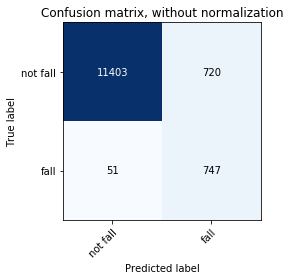

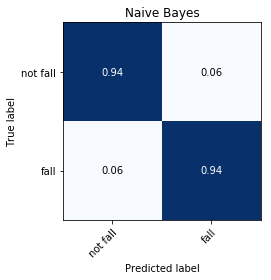

In [4]:
# CONFUSION MATRIX FOR NAIVE BAYES

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = [0, 1]

y_pred = results['prediction'].to_numpy().astype(np.int8)
y_test = results['actual'].to_numpy().astype(np.int8)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['not fall','fall']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Naive Bayes')
# plt.savefig('ConfMatrix_NB.png')
plt.show()